<a href="https://colab.research.google.com/github/RASIUT/Stock_Prediction/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install Required Libraries


In [48]:
!pip install yfinance scikit-learn pandas numpy matplotlib seaborn ta-lib

  Using cached ta_lib-0.6.3.tar.gz (376 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for ta-lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for ta-lib
Failed to build ta-lib
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (ta-lib)


##Import Libraries

In [49]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

# Set random seed for reproducibility
np.random.seed(42)

##Data Collection Function

In [50]:
def get_stock_data(symbol, period="5y"):
    """
    Fetch stock data from Yahoo Finance
    """
    try:
        stock = yf.Ticker(symbol)
        data = stock.history(period=period)

        if data.empty:
            raise ValueError(f"No data found for symbol {symbol}")

        print(f"Successfully downloaded {len(data)} days of data for {symbol}")
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

# Download stock data (you can change the symbol)
SYMBOL = "AAPL"  # Apple Inc.
stock_data = get_stock_data(SYMBOL)
print(f"\nData shape: {stock_data.shape}")
print(f"Date range: {stock_data.index[0]} to {stock_data.index[-1]}")
stock_data.head()

Successfully downloaded 1257 days of data for AAPL

Data shape: (1257, 7)
Date range: 2020-06-01 00:00:00-04:00 to 2025-05-30 00:00:00-04:00


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-06-01 00:00:00-04:00,77.218723,78.336604,77.087492,78.215096,80791200,0.0,0.0
2020-06-02 00:00:00-04:00,77.947796,78.601513,77.505502,78.577209,87642800,0.0,0.0
2020-06-03 00:00:00-04:00,78.897987,79.272236,78.324463,79.009773,104491200,0.0,0.0
2020-06-04 00:00:00-04:00,78.832370,79.131277,77.955074,78.329323,87560400,0.0,0.0
2020-06-05 00:00:00-04:00,78.579637,80.620981,78.550476,80.560226,137250400,0.0,0.0


##Data Exploration and Visualization

Stock Data Statistics:
              Open         High          Low        Close        Volume  \
count  1257.000000  1257.000000  1257.000000  1257.000000  1.257000e+03   
mean    163.926329   165.769145   162.211572   164.086742  8.084087e+07   
std      38.282425    38.556070    38.071577    38.363411  4.186587e+07   
min      77.218723    78.336604    77.087492    78.215096  2.323470e+07   
25%     136.353742   139.319095   134.767871   136.610428  5.245640e+07   
50%     161.380769   163.524288   159.974808   162.225204  7.055580e+07   
75%     187.958097   189.571754   186.665302   188.073120  9.565440e+07   
max     257.568678   259.474086   257.010028   258.396667  3.743368e+08   

         Dividends  Stock Splits  
count  1257.000000   1257.000000  
mean      0.003687      0.003182  
std       0.029081      0.112822  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       0.000000      0.000000  
max       0.260000   

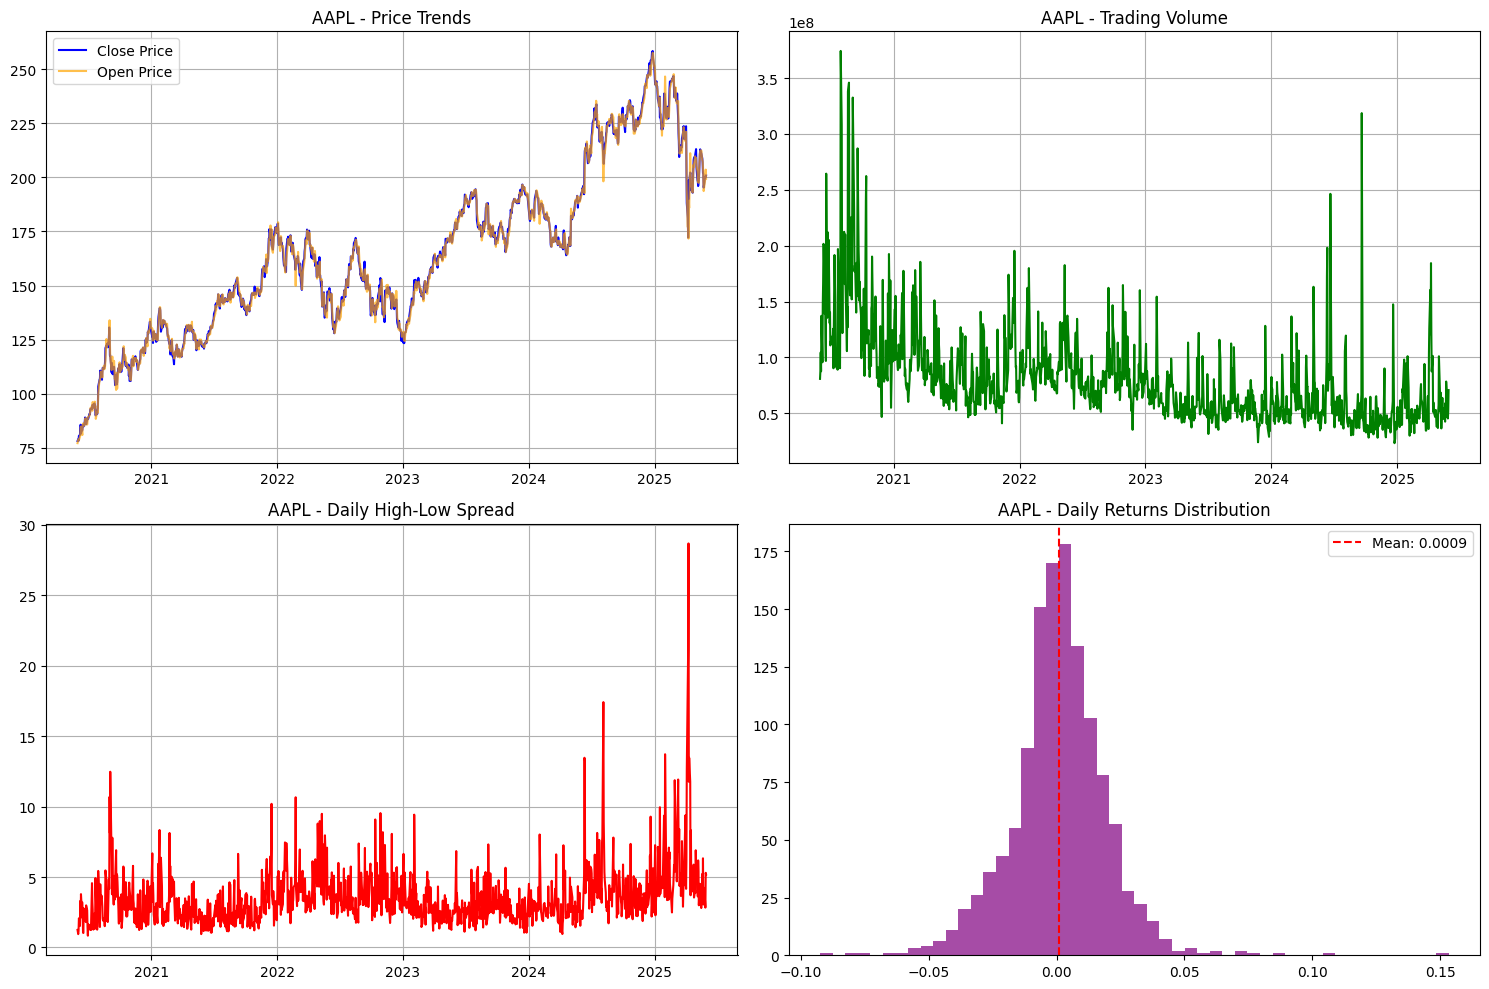


Daily Returns Statistics:
Mean: 0.0009
Std: 0.0189
Skewness: 0.3746
Kurtosis: 5.5951


In [51]:
# Basic statistics
print("Stock Data Statistics:")
print(stock_data.describe())

# Plot stock price trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price trends
axes[0,0].plot(stock_data.index, stock_data['Close'], label='Close Price', color='blue')
axes[0,0].plot(stock_data.index, stock_data['Open'], label='Open Price', color='orange', alpha=0.7)
axes[0,0].set_title(f'{SYMBOL} - Price Trends')
axes[0,0].legend()
axes[0,0].grid(True)

# Volume
axes[0,1].plot(stock_data.index, stock_data['Volume'], color='green')
axes[0,1].set_title(f'{SYMBOL} - Trading Volume')
axes[0,1].grid(True)

# High-Low spread
axes[1,0].plot(stock_data.index, stock_data['High'] - stock_data['Low'], color='red')
axes[1,0].set_title(f'{SYMBOL} - Daily High-Low Spread')
axes[1,0].grid(True)

# Returns distribution
daily_returns = stock_data['Close'].pct_change().dropna()
axes[1,1].hist(daily_returns, bins=50, alpha=0.7, color='purple')
axes[1,1].set_title(f'{SYMBOL} - Daily Returns Distribution')
axes[1,1].axvline(daily_returns.mean(), color='red', linestyle='--', label=f'Mean: {daily_returns.mean():.4f}')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print(f"\nDaily Returns Statistics:")
print(f"Mean: {daily_returns.mean():.4f}")
print(f"Std: {daily_returns.std():.4f}")
print(f"Skewness: {daily_returns.skew():.4f}")
print(f"Kurtosis: {daily_returns.kurtosis():.4f}")

##Feature Engineering Function

In [52]:
def calculate_rsi(prices, window=14):
    """Calculate RSI (Relative Strength Index)"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(prices, window=20, num_std=2):
    """Calculate Bollinger Bands"""
    rolling_mean = prices.rolling(window=window).mean()
    rolling_std = prices.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, rolling_mean, lower_band

def calculate_stochastic(high, low, close, k_window=14, d_window=3):
    """Calculate Stochastic Oscillator"""
    lowest_low = low.rolling(window=k_window).min()
    highest_high = high.rolling(window=k_window).max()
    k_percent = 100 * ((close - lowest_low) / (highest_high - lowest_low))
    d_percent = k_percent.rolling(window=d_window).mean()
    return k_percent, d_percent

def create_features(data):
    """
    Create comprehensive features for stock prediction
    """
    df = data.copy()

    # Basic price features
    df['Price_Range'] = df['High'] - df['Low']
    df['Price_Change'] = df['Close'] - df['Open']
    df['Price_Change_Pct'] = (df['Close'] - df['Open']) / df['Open']

    # Moving averages
    for window in [5, 10, 20, 50]:
        df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'Close_MA_{window}_ratio'] = df['Close'] / df[f'MA_{window}']

    # Exponential moving averages
    for span in [12, 26]:
        df[f'EMA_{span}'] = df['Close'].ewm(span=span).mean()

    # MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_signal'] = df['MACD'].ewm(span=9).mean()
    df['MACD_histogram'] = df['MACD'] - df['MACD_signal']

    # RSI
    df['RSI'] = calculate_rsi(df['Close'])

    # Bollinger Bands
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = calculate_bollinger_bands(df['Close'])
    df['BB_width'] = df['BB_upper'] - df['BB_lower']
    df['BB_position'] = (df['Close'] - df['BB_lower']) / df['BB_width']

    # Stochastic Oscillator
    df['Stoch_K'], df['Stoch_D'] = calculate_stochastic(df['High'], df['Low'], df['Close'])

    # Williams %R
    df['Williams_R'] = -100 * ((df['High'].rolling(14).max() - df['Close']) /
                               (df['High'].rolling(14).max() - df['Low'].rolling(14).min()))

    # Commodity Channel Index (CCI)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = typical_price.rolling(20).mean()
    mad = typical_price.rolling(20).apply(lambda x: np.abs(x - x.mean()).mean())
    df['CCI'] = (typical_price - sma_tp) / (0.015 * mad)

    # Average True Range (ATR)
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = true_range.rolling(14).mean()

    # Money Flow Index (MFI)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    money_flow = typical_price * df['Volume']
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0).rolling(14).sum()
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0).rolling(14).sum()
    mfi_ratio = positive_flow / negative_flow
    df['MFI'] = 100 - (100 / (1 + mfi_ratio))

    # Volume features
    df['Volume_MA_10'] = df['Volume'].rolling(window=10).mean()
    df['Volume_ratio'] = df['Volume'] / df['Volume_MA_10']
    df['Price_Volume'] = df['Close'] * df['Volume']
    df['Volume_Price_Trend'] = df['Volume'] * df['Price_Change_Pct']

    # On Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # Volatility features
    df['Volatility_10'] = df['Close'].rolling(window=10).std()
    df['Volatility_20'] = df['Close'].rolling(window=20).std()
    df['Volatility_ratio'] = df['Volatility_10'] / df['Volatility_20']

    # Price momentum
    for period in [1, 3, 5, 10]:
        df[f'Momentum_{period}'] = df['Close'] / df['Close'].shift(period) - 1

    # Rate of Change (ROC)
    for period in [5, 10, 20]:
        df[f'ROC_{period}'] = ((df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period)) * 100

    # Lag features
    for lag in [1, 2, 3, 5]:
        df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
        df[f'Volume_lag_{lag}'] = df['Volume'].shift(lag)
        df[f'Return_lag_{lag}'] = df['Close'].pct_change(lag)
        df[f'High_lag_{lag}'] = df['High'].shift(lag)
        df[f'Low_lag_{lag}'] = df['Low'].shift(lag)

    # Rolling statistics
    for window in [5, 10, 20]:
        df[f'Close_rolling_max_{window}'] = df['Close'].rolling(window=window).max()
        df[f'Close_rolling_min_{window}'] = df['Close'].rolling(window=window).min()
        df[f'Close_rolling_std_{window}'] = df['Close'].rolling(window=window).std()
        df[f'Close_rolling_skew_{window}'] = df['Close'].rolling(window=window).skew()
        df[f'Volume_rolling_mean_{window}'] = df['Volume'].rolling(window=window).mean()

    # Price position within ranges
    for window in [10, 20]:
        rolling_min = df['Close'].rolling(window=window).min()
        rolling_max = df['Close'].rolling(window=window).max()
        df[f'Price_position_{window}'] = (df['Close'] - rolling_min) / (rolling_max - rolling_min)

    # Gap analysis
    df['Gap'] = df['Open'] - df['Close'].shift(1)
    df['Gap_pct'] = df['Gap'] / df['Close'].shift(1)

    # Intraday features
    df['Intraday_return'] = (df['Close'] - df['Open']) / df['Open']
    df['High_Low_pct'] = (df['High'] - df['Low']) / df['Low']
    df['Close_High_ratio'] = df['Close'] / df['High']
    df['Close_Low_ratio'] = df['Close'] / df['Low']

    # Time-based features
    df['Day_of_week'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Day_of_month'] = df.index.day
    df['Week_of_year'] = df.index.isocalendar().week

    # Seasonal features (cyclical encoding)
    df['Day_of_week_sin'] = np.sin(2 * np.pi * df['Day_of_week'] / 7)
    df['Day_of_week_cos'] = np.cos(2 * np.pi * df['Day_of_week'] / 7)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Quarter_sin'] = np.sin(2 * np.pi * df['Quarter'] / 4)
    df['Quarter_cos'] = np.cos(2 * np.pi * df['Quarter'] / 4)

    # Market regime features
    df['Bull_Bear_20'] = np.where(df['Close'] > df['MA_20'], 1, 0)
    df['Bull_Bear_50'] = np.where(df['Close'] > df['MA_50'], 1, 0)
    df['MA_20_50_cross'] = np.where(df['MA_20'] > df['MA_50'], 1, 0)

    return df

# Apply feature engineering
print("Creating features...")
featured_data = create_features(stock_data)
print(f"Original features: {len(stock_data.columns)}")
print(f"Total features after engineering: {len(featured_data.columns)}")

Creating features...
Original features: 7
Total features after engineering: 107


##Data Preprocessing


In [53]:
def prepare_data_for_modeling(data, target_col='Close', prediction_days=1):
    """
    Prepare data for machine learning models
    """
    df = data.copy()

    # Create target variable (next day's closing price)
    df['Target'] = df[target_col].shift(-prediction_days)

    # Remove rows with NaN values
    df_clean = df.dropna()

    # Select feature columns (exclude target and original OHLCV columns)
    exclude_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Target']
    feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

    # Separate features and target
    X = df_clean[feature_cols]
    y = df_clean['Target']

    print(f"Features selected: {len(feature_cols)}")
    print(f"Samples available: {len(X)}")

    return X, y, feature_cols

# Prepare data
X, y, feature_columns = prepare_data_for_modeling(featured_data)

# Display feature importance preview
print("\nFeature columns:")
for i, col in enumerate(feature_columns[:20]):  # Show first 20 features
    print(f"{i+1:2d}. {col}")
if len(feature_columns) > 20:
    print(f"... and {len(feature_columns)-20} more features")

Features selected: 100
Samples available: 1207

Feature columns:
 1. Price_Range
 2. Price_Change
 3. Price_Change_Pct
 4. MA_5
 5. Close_MA_5_ratio
 6. MA_10
 7. Close_MA_10_ratio
 8. MA_20
 9. Close_MA_20_ratio
10. MA_50
11. Close_MA_50_ratio
12. EMA_12
13. EMA_26
14. MACD
15. MACD_signal
16. MACD_histogram
17. RSI
18. BB_upper
19. BB_middle
20. BB_lower
... and 80 more features


##Train-Test Split with Time Series Consideration

In [54]:
def time_series_split(X, y, test_size=0.2):
    """
    Split time series data maintaining temporal order
    """
    split_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = time_series_split(X, y, test_size=0.2)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training period: {X_train.index[0]} to {X_train.index[-1]}")
print(f"Test period: {X_test.index[0]} to {X_test.index[-1]}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)


Training set: 965 samples
Test set: 242 samples
Training period: 2020-08-10 00:00:00-04:00 to 2024-06-10 00:00:00-04:00
Test period: 2024-06-11 00:00:00-04:00 to 2025-05-29 00:00:00-04:00


##Feature Selection

In [55]:
# Feature selection using SelectKBest
k_best = 25  # Select top 25 features
selector = SelectKBest(score_func=f_regression, k=k_best)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_features = np.array(feature_columns)[selector.get_support()]
print(f"Selected {len(selected_features)} most important features:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

# Convert back to DataFrame
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)

Selected 25 most important features:
 1. MA_5
 2. MA_10
 3. MA_20
 4. EMA_12
 5. EMA_26
 6. BB_upper
 7. BB_middle
 8. Close_lag_1
 9. High_lag_1
10. Low_lag_1
11. Close_lag_2
12. High_lag_2
13. Low_lag_2
14. Close_lag_3
15. High_lag_3
16. Low_lag_3
17. Close_lag_5
18. High_lag_5
19. Low_lag_5
20. Close_rolling_max_5
21. Close_rolling_min_5
22. Close_rolling_max_10
23. Close_rolling_min_10
24. Close_rolling_max_20
25. Close_rolling_min_20


## Model Definition and Training

In [56]:
def train_models(X_train, y_train, X_test, y_test):
    """
    Train multiple models and compare performance
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42
        ),
        'SVR': SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
    }

    results = {}
    trained_models = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        results[name] = {
            'Train MSE': train_mse,
            'Test MSE': test_mse,
            'Train MAE': train_mae,
            'Test MAE': test_mae,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Train RMSE': np.sqrt(train_mse),
            'Test RMSE': np.sqrt(test_mse),
            'Predictions': y_test_pred
        }

        trained_models[name] = model

        print(f"  Test RMSE: {np.sqrt(test_mse):.4f}")
        print(f"  Test MAE: {test_mae:.4f}")
        print(f"  Test R²: {test_r2:.4f}")

    return results, trained_models

# Train all models
print("Training multiple models...")
model_results, trained_models = train_models(X_train_selected, y_train, X_test_selected, y_test)

Training multiple models...

Training Linear Regression...
  Test RMSE: 4.6655
  Test MAE: 3.3859
  Test R²: 0.8994

Training Ridge Regression...
  Test RMSE: 5.0865
  Test MAE: 3.8643
  Test R²: 0.8804

Training Lasso Regression...
  Test RMSE: 6.1148
  Test MAE: 4.6218
  Test R²: 0.8272

Training Random Forest...
  Test RMSE: 31.3856
  Test MAE: 28.3633
  Test R²: -3.5530

Training Gradient Boosting...
  Test RMSE: 34.7618
  Test MAE: 31.9809
  Test R²: -4.5852

Training SVR...
  Test RMSE: 61.8521
  Test MAE: 57.2951
  Test R²: -16.6825


##Model Performance Comparison

Model Performance Comparison:
                   Test RMSE  Test MAE  Test R²  Train R²
Linear Regression     4.6655    3.3859   0.8994    0.9858
Ridge Regression      5.0865    3.8643   0.8804    0.9835
Lasso Regression      6.1148    4.6218   0.8272    0.9771
Random Forest        31.3856   28.3633  -3.5530    0.9957
Gradient Boosting    34.7618   31.9809  -4.5852    0.9993
SVR                  61.8521   57.2951 -16.6825    0.9843


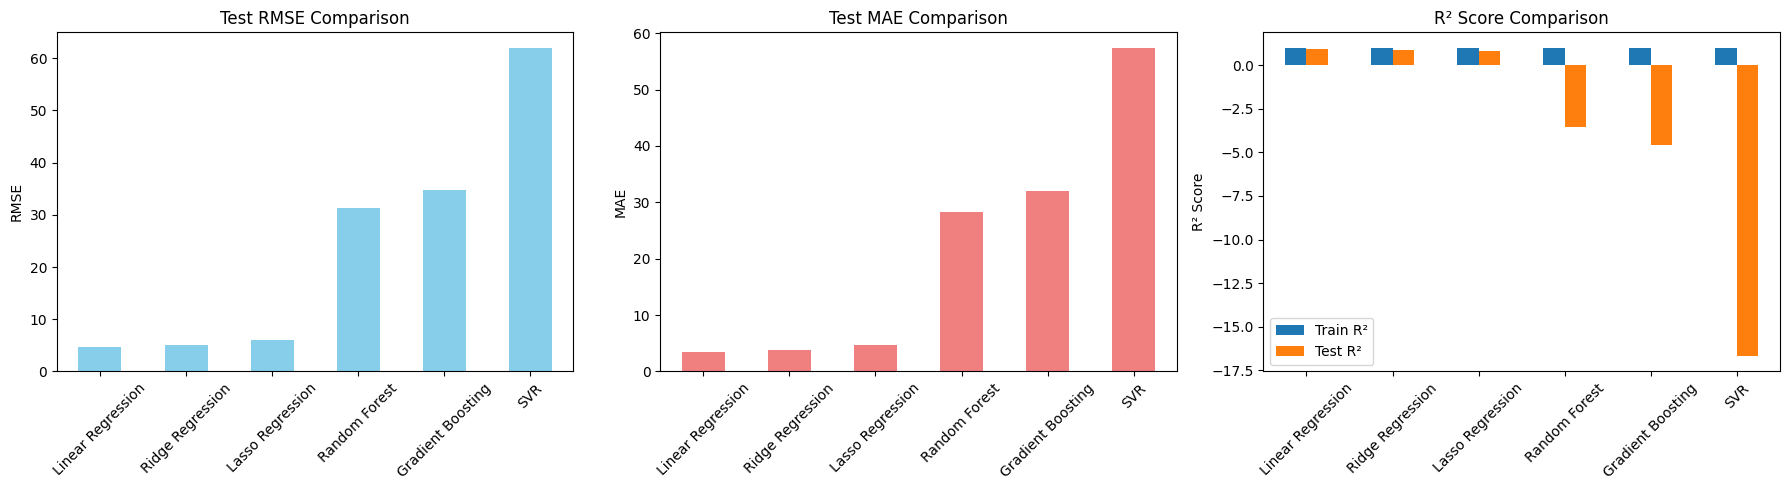


Best performing model: Linear Regression
Test R² Score: 0.8994


In [57]:
# Create performance comparison DataFrame
performance_df = pd.DataFrame({
    model: {
        'Test RMSE': results['Test RMSE'],
        'Test MAE': results['Test MAE'],
        'Test R²': results['Test R²'],
        'Train R²': results['Train R²']
    }
    for model, results in model_results.items()
}).T

print("Model Performance Comparison:")
print(performance_df.round(4))

# Visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE comparison
performance_df['Test RMSE'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Test RMSE Comparison')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison
performance_df['Test MAE'].plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Test MAE Comparison')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

# R² comparison
performance_df[['Train R²', 'Test R²']].plot(kind='bar', ax=axes[2])
axes[2].set_title('R² Score Comparison')
axes[2].set_ylabel('R² Score')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend()

plt.tight_layout()
plt.show()

# Find best model
best_model_name = performance_df['Test R²'].idxmax()
print(f"\nBest performing model: {best_model_name}")
print(f"Test R² Score: {performance_df.loc[best_model_name, 'Test R²']:.4f}")

##Hyperparameter Tuning for Best Model

In [58]:
def tune_best_model(X_train, y_train, model_name, trained_models):
    """
    Perform hyperparameter tuning for the best model
    """
    if model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [8, 10, 12],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        base_model = RandomForestRegressor(random_state=42)

    elif model_name == 'Gradient Boosting':
        param_grid = {
            'n_estimators': [100, 150],
            'max_depth': [4, 6, 8],
            'learning_rate': [0.05, 0.1, 0.15]
        }
        base_model = GradientBoostingRegressor(random_state=42)

    else:
        print(f"No hyperparameter tuning defined for {model_name}")
        return trained_models[model_name]

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    print(f"Tuning hyperparameters for {model_name}...")
    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {-grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

# Tune the best model
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    best_tuned_model = tune_best_model(X_train_selected, y_train, best_model_name, trained_models)
else:
    best_tuned_model = trained_models[best_model_name]
    print(f"Using {best_model_name} without additional tuning")

Using Linear Regression without additional tuning


##Final Model Evaluation and Predictions

In [59]:
# Make final predictions with tuned model
y_train_pred_final = best_tuned_model.predict(X_train_selected)
y_test_pred_final = best_tuned_model.predict(X_test_selected)

# Calculate final metrics
final_train_r2 = r2_score(y_train, y_train_pred_final)
final_test_r2 = r2_score(y_test, y_test_pred_final)
final_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_final))
final_test_mae = mean_absolute_error(y_test, y_test_pred_final)

print("Final Model Performance:")
print(f"Train R²: {final_train_r2:.4f}")
print(f"Test R²: {final_test_r2:.4f}")
print(f"Test RMSE: {final_test_rmse:.4f}")
print(f"Test MAE: {final_test_mae:.4f}")

# Calculate percentage error
mean_price = y_test.mean()
percentage_error = (final_test_rmse / mean_price) * 100
print(f"Average percentage error: {percentage_error:.2f}%")

# Feature importance (if available)
if hasattr(best_tuned_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_tuned_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    feature_importance.head(15).plot(x='feature', y='importance', kind='barh')
    plt.title('Top 15 Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

Final Model Performance:
Train R²: 0.9858
Test R²: 0.8994
Test RMSE: 4.6655
Test MAE: 3.3859
Average percentage error: 2.08%


##Prediction Visualization

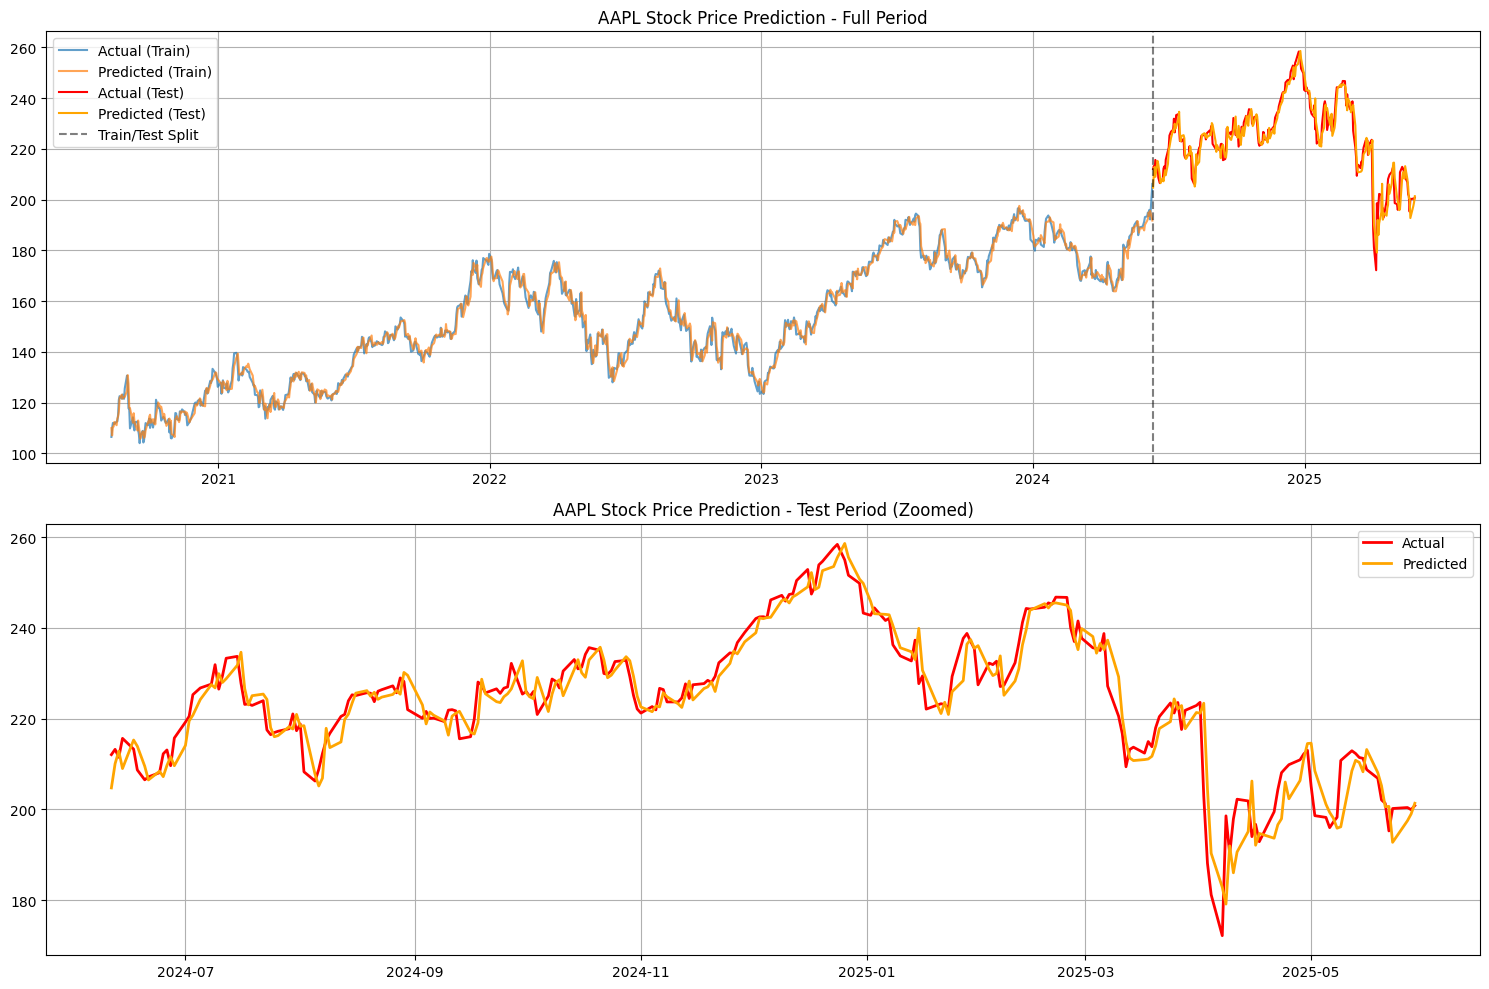

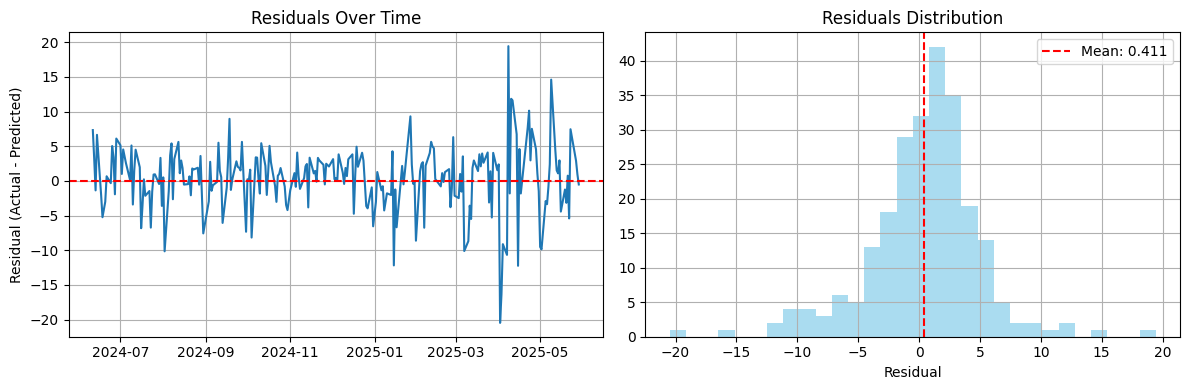

Residual Statistics:
Mean: 0.4114
Std: 4.6474
Min: -20.4784
Max: 19.4370


In [60]:
# Create prediction visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Full period comparison
axes[0].plot(y_train.index, y_train.values, label='Actual (Train)', alpha=0.7)
axes[0].plot(y_train.index, y_train_pred_final, label='Predicted (Train)', alpha=0.7)
axes[0].plot(y_test.index, y_test.values, label='Actual (Test)', color='red')
axes[0].plot(y_test.index, y_test_pred_final, label='Predicted (Test)', color='orange')
axes[0].axvline(x=y_test.index[0], color='black', linestyle='--', alpha=0.5, label='Train/Test Split')
axes[0].set_title(f'{SYMBOL} Stock Price Prediction - Full Period')
axes[0].legend()
axes[0].grid(True)

# Zoomed view of test period
axes[1].plot(y_test.index, y_test.values, label='Actual', color='red', linewidth=2)
axes[1].plot(y_test.index, y_test_pred_final, label='Predicted', color='orange', linewidth=2)
axes[1].set_title(f'{SYMBOL} Stock Price Prediction - Test Period (Zoomed)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Residual analysis
residuals = y_test.values - y_test_pred_final
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Residuals over time
axes[0].plot(y_test.index, residuals)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('Residuals Over Time')
axes[0].set_ylabel('Residual (Actual - Predicted)')
axes[0].grid(True)

# Residuals distribution
axes[1].hist(residuals, bins=30, alpha=0.7, color='skyblue')
axes[1].axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.3f}')
axes[1].set_title('Residuals Distribution')
axes[1].set_xlabel('Residual')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Residual Statistics:")
print(f"Mean: {residuals.mean():.4f}")
print(f"Std: {residuals.std():.4f}")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")

##Future Prediction Function

In [61]:
def predict_future_prices(model, scaler, selector, data, days_ahead=5):
    """
    Predict future stock prices
    """
    # Get the latest features
    latest_data = create_features(data).dropna().tail(1)

    # Prepare features (same as training)
    exclude_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Target']
    feature_cols = [col for col in latest_data.columns if col not in exclude_cols]

    X_latest = latest_data[feature_cols]
    X_latest_scaled = scaler.transform(X_latest)
    X_latest_selected = selector.transform(X_latest_scaled)

    # Make prediction
    prediction = model.predict(X_latest_selected)[0]

    print(f"Latest closing price: ${data['Close'].iloc[-1]:.2f}")
    print(f"Predicted next day price: ${prediction:.2f}")
    print(f"Predicted change: ${prediction - data['Close'].iloc[-1]:.2f} ({((prediction/data['Close'].iloc[-1] - 1)*100):+.2f}%)")

    return prediction

# Make future prediction
print("Making future prediction...")
future_prediction = predict_future_prices(
    best_tuned_model,
    scaler,
    selector,
    stock_data
)

Making future prediction...
Latest closing price: $200.85
Predicted next day price: $199.58
Predicted change: $-1.27 (-0.63%)


##Model Saving and Summary

In [62]:
import pickle
from datetime import datetime

# Save the trained model and preprocessors
model_artifacts = {
    'model': best_tuned_model,
    'scaler': scaler,
    'selector': selector,
    'selected_features': selected_features,
    'model_name': best_model_name,
    'performance_metrics': {
        'test_r2': final_test_r2,
        'test_rmse': final_test_rmse,
        'test_mae': final_test_mae,
        'percentage_error': percentage_error
    },
    'symbol': SYMBOL,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save to file
with open(f'{SYMBOL}_stock_prediction_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("Model saved successfully!")

# Print comprehensive summary
print("\n" + "="*60)
print("STOCK PRICE PREDICTION MODEL SUMMARY")
print("="*60)
print(f"Stock Symbol: {SYMBOL}")
print(f"Model Type: {best_model_name}")
print(f"Training Data: {len(X_train)} samples")
print(f"Test Data: {len(X_test)} samples")
print(f"Features Used: {len(selected_features)}")
print("\nPerformance Metrics:")
print(f"  Test R² Score: {final_test_r2:.4f}")
print(f"  Test RMSE: ${final_test_rmse:.2f}")
print(f"  Test MAE: ${final_test_mae:.2f}")
print(f"  Average Error: {percentage_error:.2f}%")
print(f"\nNext Day Prediction: ${future_prediction:.2f}")
print("="*60)

# Trading signal based on prediction
current_price = stock_data['Close'].iloc[-1]
if future_prediction > current_price * 1.01:  # >1% increase
    signal = "BUY"
elif future_prediction < current_price * 0.99:  # >1% decrease
    signal = "SELL"
else:
    signal = "HOLD"

print(f"Trading Signal: {signal}")
print("="*60)

Model saved successfully!

STOCK PRICE PREDICTION MODEL SUMMARY
Stock Symbol: AAPL
Model Type: Linear Regression
Training Data: 965 samples
Test Data: 242 samples
Features Used: 25

Performance Metrics:
  Test R² Score: 0.8994
  Test RMSE: $4.67
  Test MAE: $3.39
  Average Error: 2.08%

Next Day Prediction: $199.58
Trading Signal: HOLD
